# Reference level cross validation
In scenarios where you have no prior knowledge of the elevation of the density contrast of interest, we use a flat starting model with an arbitrary reference level. The reference level (`zref`) is very important to the inversion as different values can vertically shift the inverted topography. Here we present a cross-validation approach to determine the optimal value for `zref`. This follows the same approach as the past notebook (`density_cross_validation.ipynb`). To simplify, we assume we know the appropiate density constrast value to use. 

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pathlib
import pickle

import numpy as np
import verde as vd
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data

### True topography

In [2]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1
(
    true_topography,
    _,
    constraint_points,
    observed_gravity,
) = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    number_of_constraints=10,
    density_contrast=true_density_contrast,
    gravity_noise=0.2,
    plot_topography_diff=False,
)

true_zref = true_topography.values.mean()
print(f"mean of true topography: {true_zref} m ")

plotting failed with error: 'DataArray' object has no attribute 'to_xarray'


mean of true topography: 492.2704164812973 m 


For simplicity here we assume that we know the optimal density contrast value and use this when creating our starting model.

What we don't know in this scenario is what reference elevation `zref` to use. We will use a cross-validation of a range of elevations to find the one which is optimal.

Each `zref` will give a cross validation score, and the lowest score will show which `zref` is optimal. 

The cross validation score is calculated as the root mean square error between the points of known topography (`constraints`) and the inverted topography at those points, same as in the past nootebook. 

## Get Cross Validation Score

First we need to use the `zref` value to create the starting model. We will then use this in an inversion to calculate a `score`.

In [3]:
data = invert4geom.create_data(observed_gravity)

# make a flat grid at the height of the zref
grid_coords = vd.grid_coordinates(region=data.region, spacing=data.spacing)
starting_topography = vd.make_xarray_grid(
    grid_coords, data=np.ones_like(grid_coords[0]) * true_zref, data_names="upward"
)

model = invert4geom.create_model(
    zref=300,  # instead of the correct value of ~490 m,
    density_contrast=true_density_contrast,
    starting_topography=starting_topography,
)

In [4]:
data.inv.forward_gravity(
    model,
    progressbar=True,
)

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
data.inv.regional_separation(
    method="constant",
    constant=0,
)

  0%|          | 0/1271 [00:00<?, ?it/s]

makecpt [ERROR]: Option T: min >= max
supplied min value is greater or equal to max value
Grid/points are a constant value, can't make a colorbar histogram!


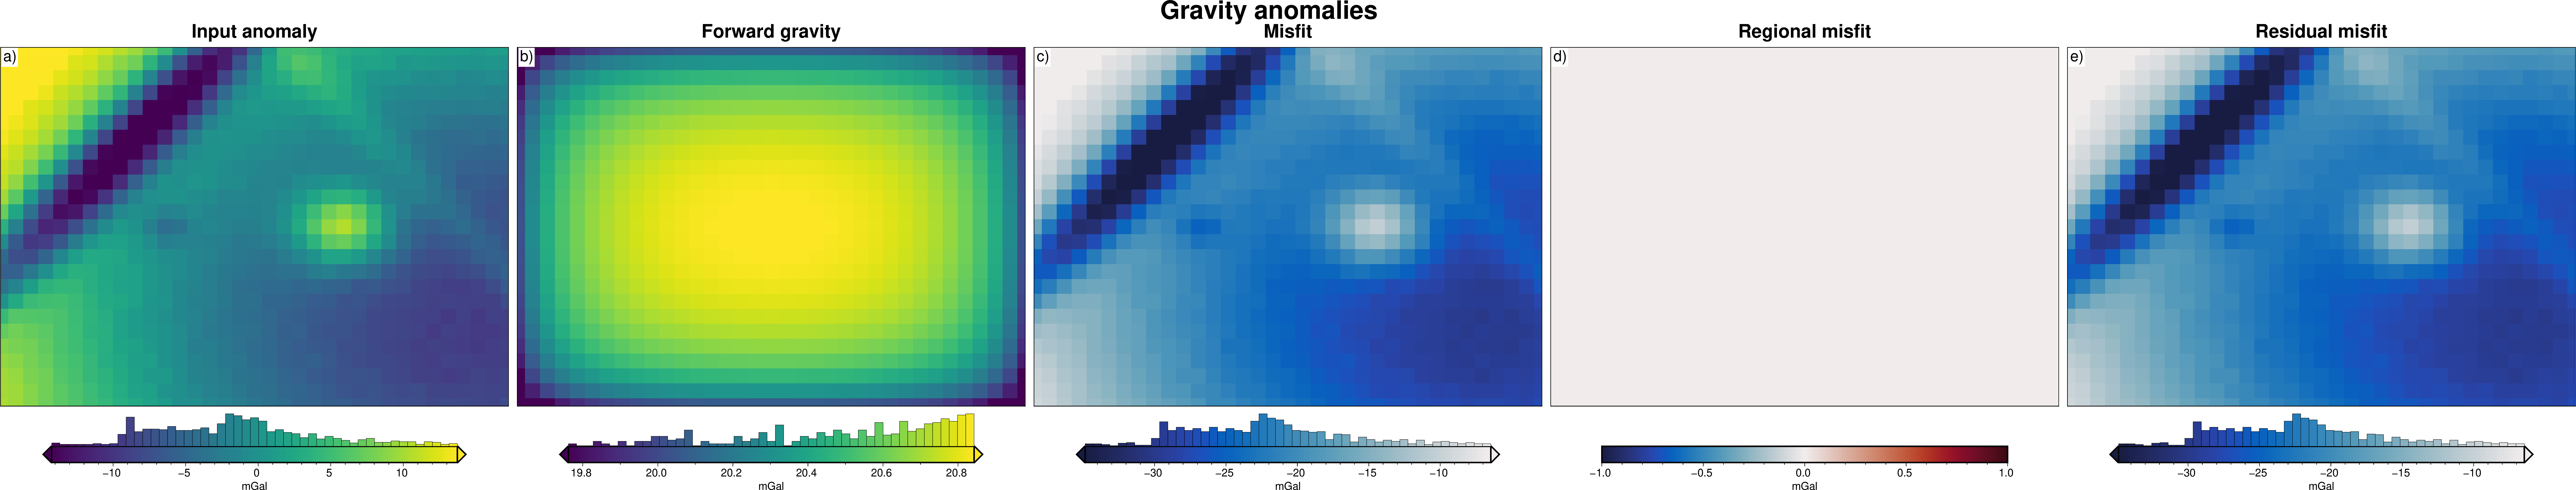

In [5]:
data.inv.plot_anomalies()

In [6]:
# setup the inversion
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.45,
    delta_l2_norm_tolerance=1.005,
)

In [7]:
# run inversion, calculate the score
constraints_cv_object = inv.constraints_cv_score(constraints_df=constraint_points)
inv.constraints_cv_best_score

np.float64(195.0124438881852)

## Cross Validation
Lets see if we can improve the score with other values for zref. For each zref value we need to recreate the starting prism model, forward calculate its starting gravity, and recalculate the gravity misfit, including the regional and residual components. Then we can re-run the inversion.

This is a classic optimization problem, where we vary the zref to find which value produces the best score. For this we use the Python package [Optuna](https://optuna.readthedocs.io/en/stable/index.html). 

For each trial a `.pickle` file containing the inversion results will be created. Once all trials are complete, all but the best trial's pickle files will be deleted. Additionally, another `.pickle` file will be created containing the Optuna study object with all the trial information and results.

By default, `optimize_inversion_zref_density_contrast` will use a sampler to choose zref values between the provided `zref_limits` and repeat this `n_trials` times. This may skip large portions of the parameter space. If instead you would like to systematically test zref values at a constant interval, you can set `grid_search` to True, and this will test all zref values as defined by:

```python
np.linspace(<<lower zref limit>>, <<upper zref limit>>, n_trials)
```

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

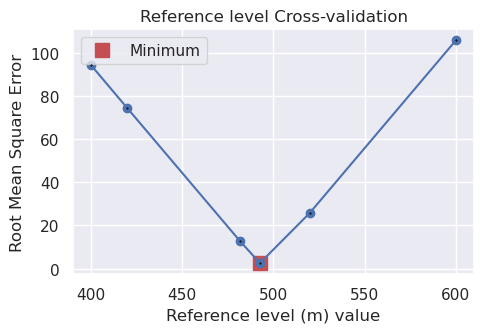

In [8]:
density_cv_obj = inv.optimize_inversion_zref_density_contrast(
    constraints_df=constraint_points,
    zref_limits=(400, 600),
    n_trials=6,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    starting_topography_kwargs={
        "method": "flat",
        "region": inv.model.region,
        "spacing": inv.model.spacing,
    },
    # grid_search=True,
    plot_cv=True,
    fname="../tmp/06_zref_CV",
    fold_progressbar=True,
)

In [9]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/06_zref_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/06_zref_CV_results.pickle").open("rb") as f:
    inv_results = pickle.load(f)

In [10]:
# fig = plotting.plot_cv_scores(
#     study.trials_dataframe().value.values,
#     study.trials_dataframe().params_zref.values,
#     param_name="Reference level",
#     logx=False,
#     logy=False,
# )

Lets see how the cross-validation perform by comparing the estimated `best` reference level value to the true value used to create the observed gravity.

In [11]:
print(f"True zref value: {true_zref}, best zref from CV: {inv_results.model.zref}")

True zref value: 492.2704164812973, best zref from CV: 492.53501469235925


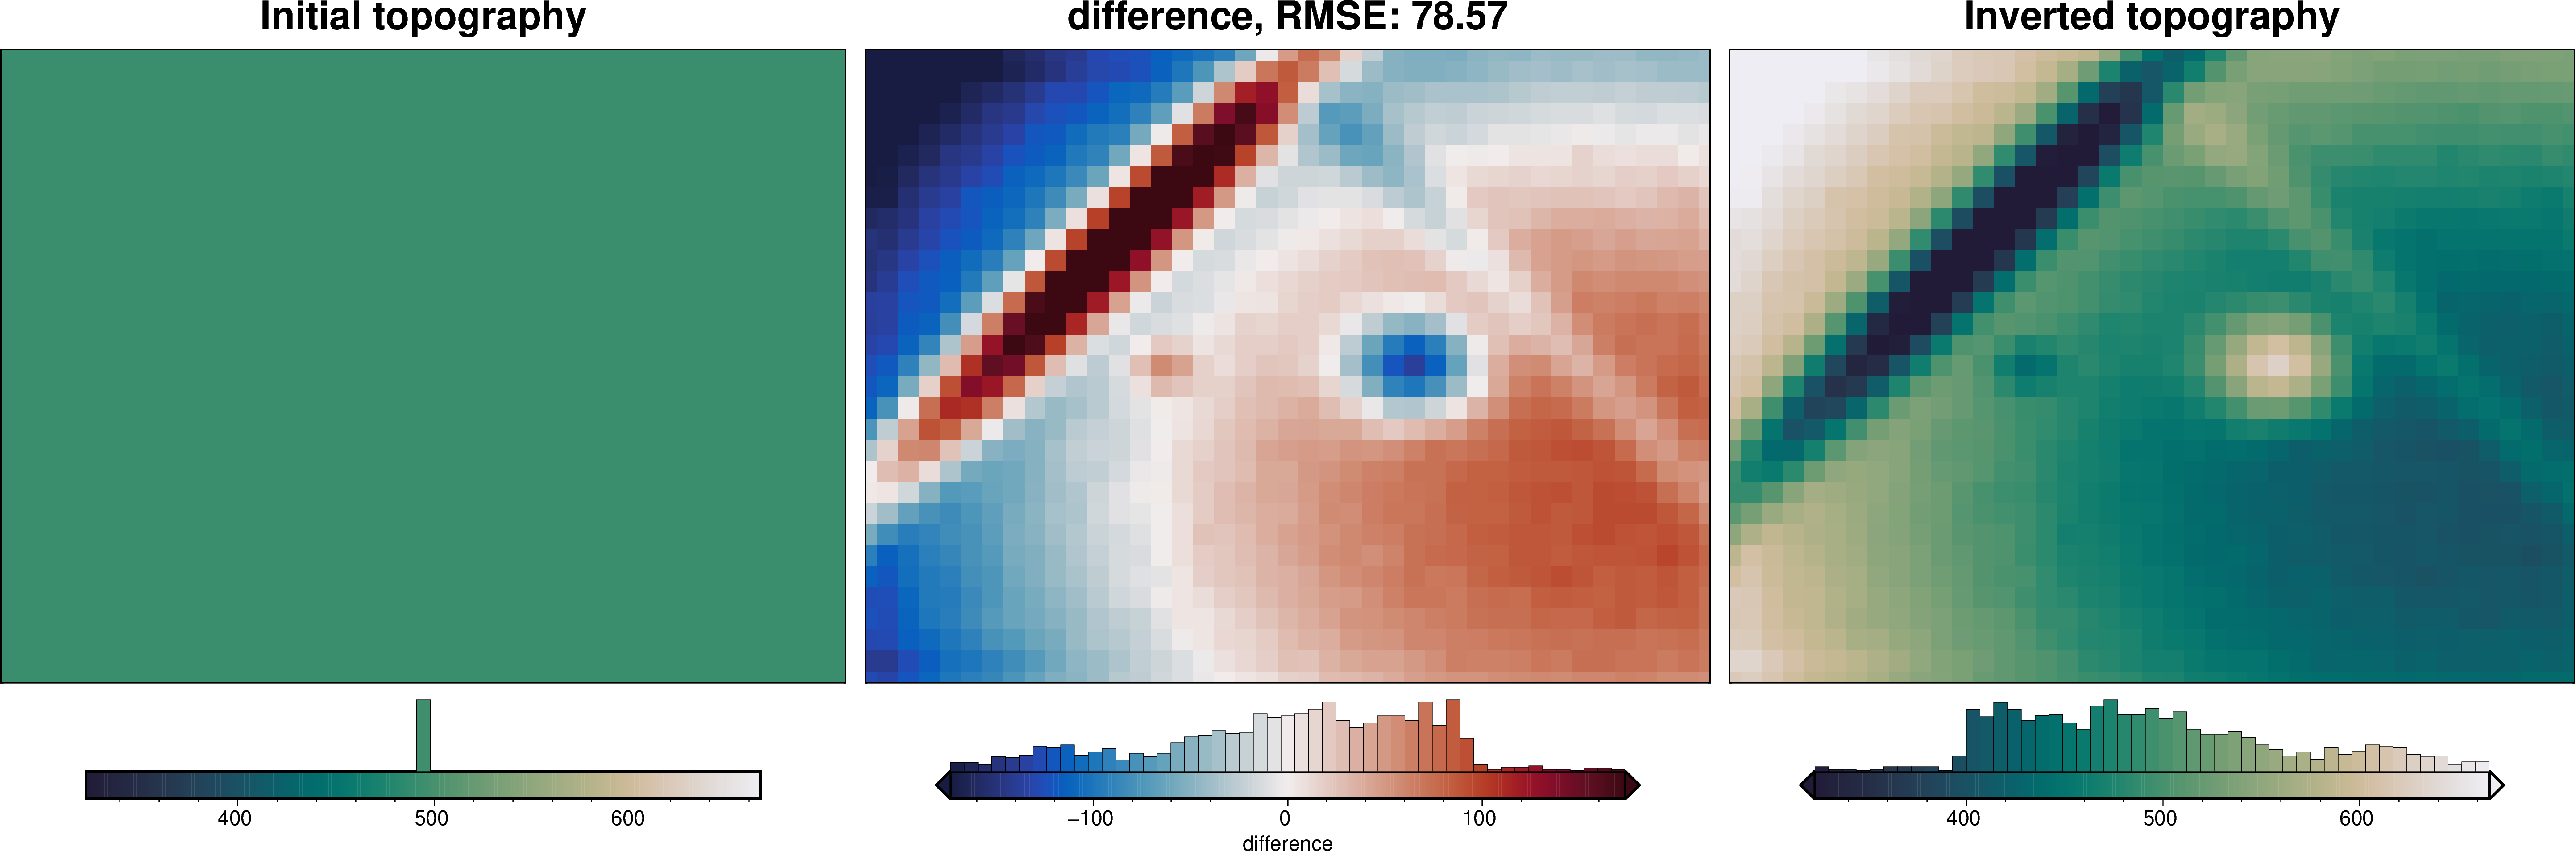

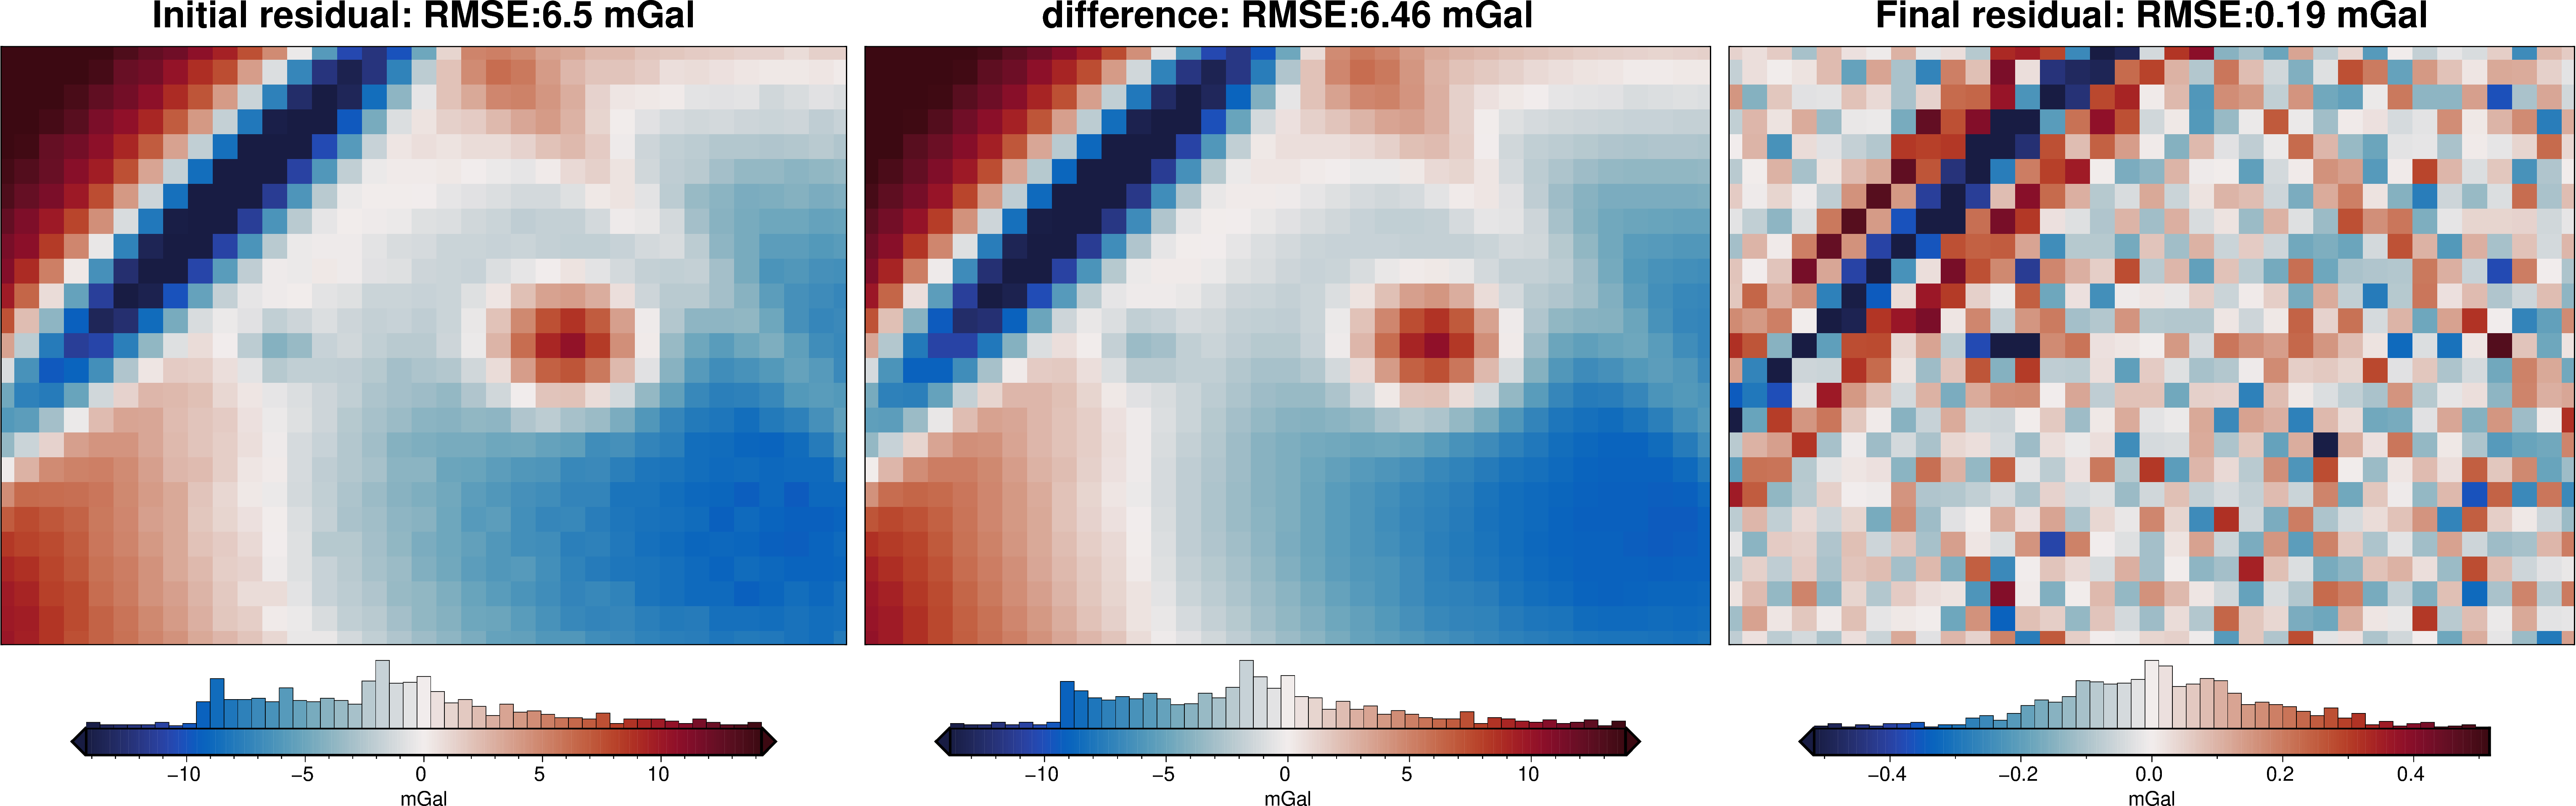

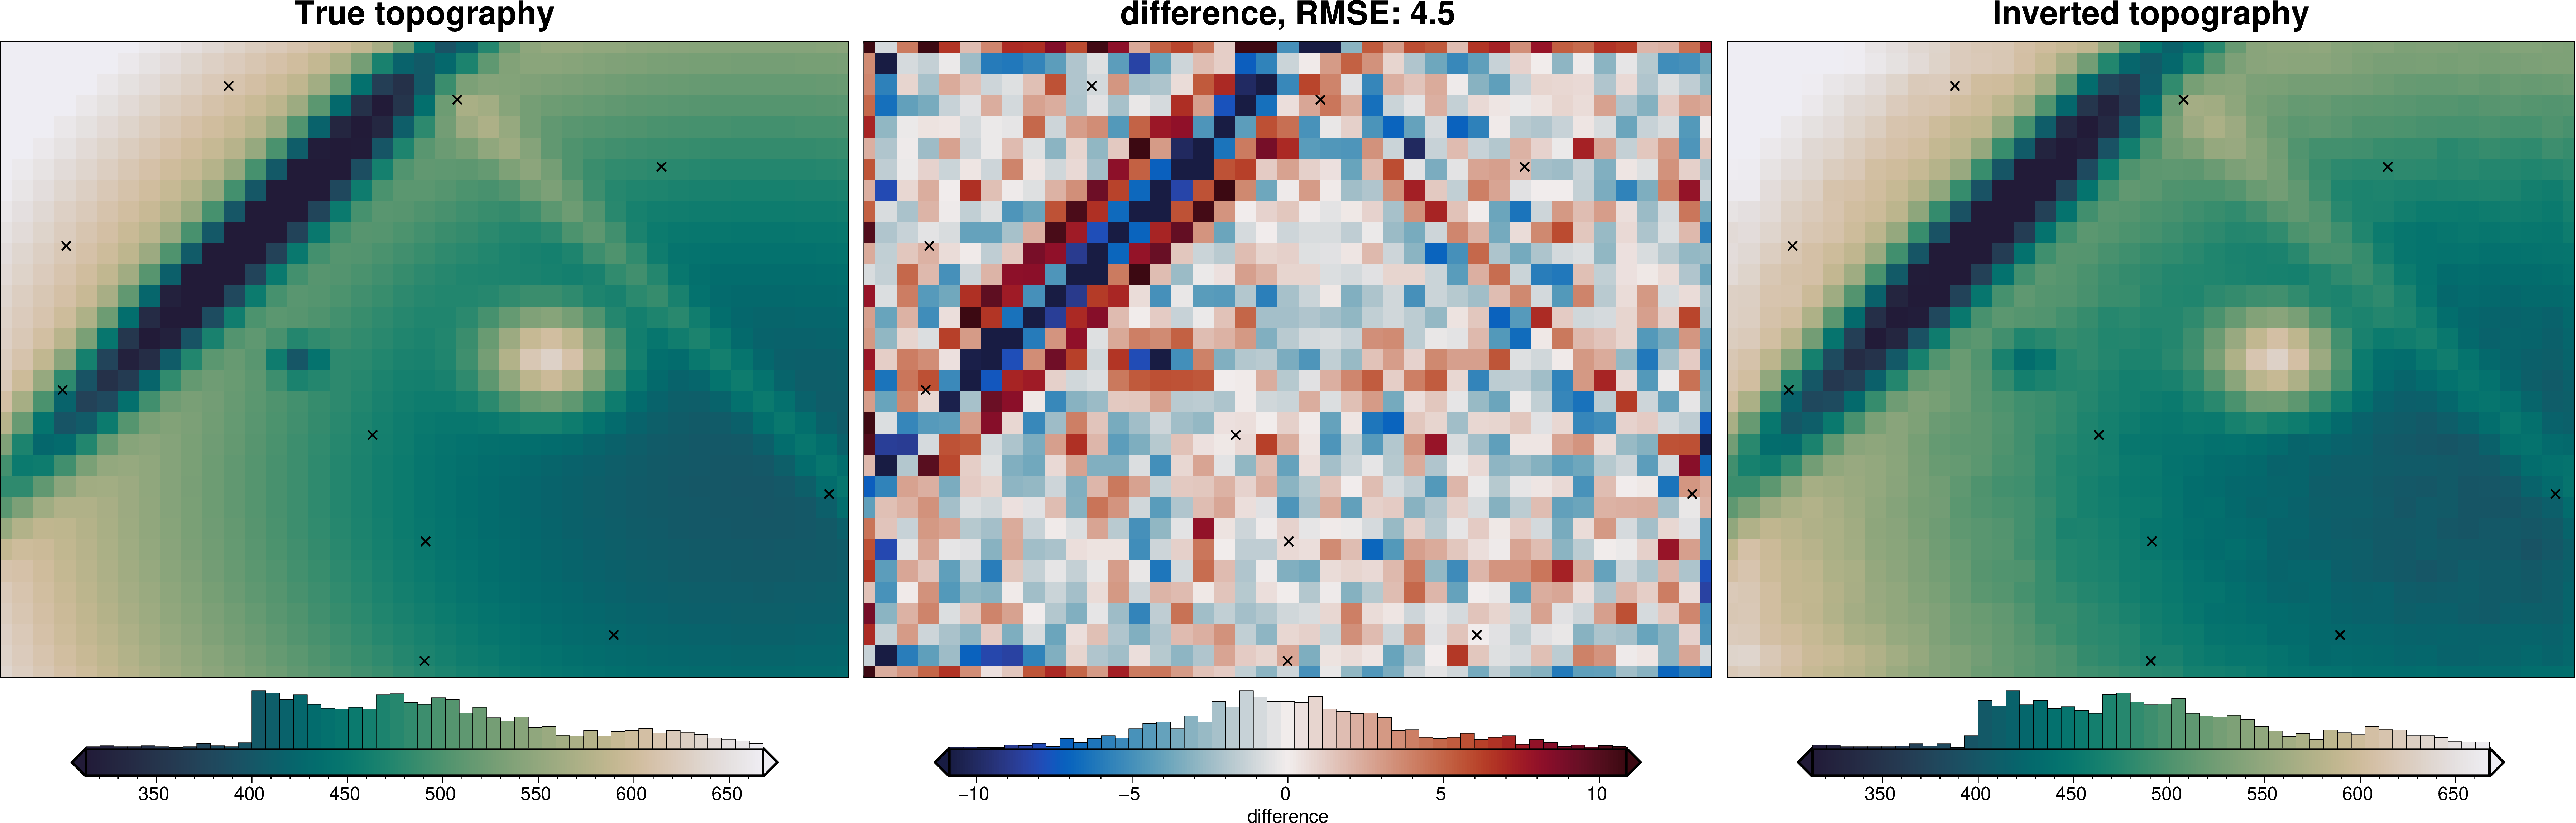

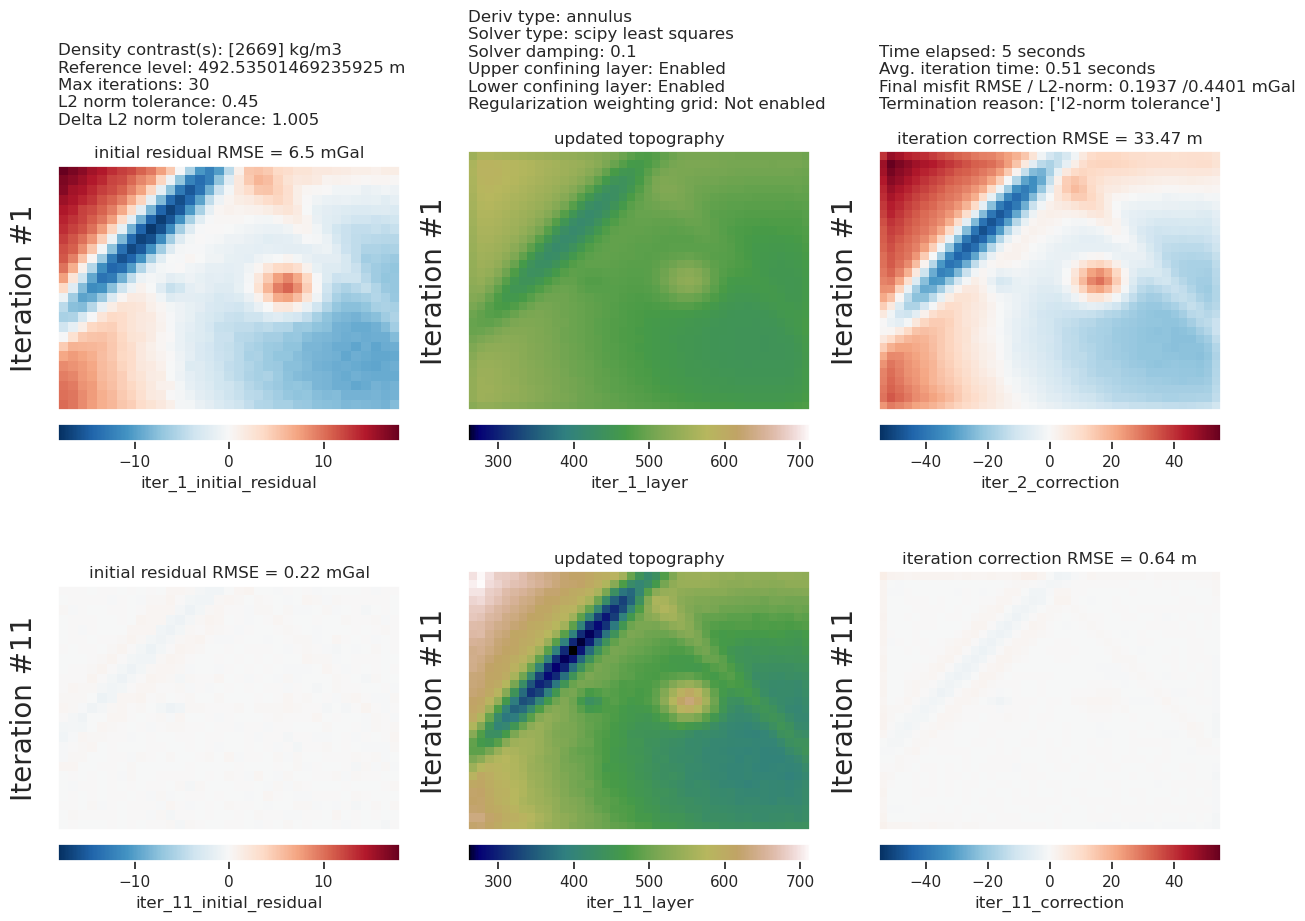

In [12]:
inv_results.plot_inversion_results(iters_to_plot=2)

_ = polar_utils.grd_compare(
    true_topography,
    inv_results.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Run inversion with poor choice of reference level

In [14]:
# set a bad reference level
bad_zref = 300

bad_zref_results = invert4geom.run_inversion_workflow(
    grav_ds=data,
    create_starting_topography=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    density_contrast=true_density_contrast,
    zref=bad_zref,
    fname="../tmp/06_bad_zref",
    starting_topography_kwargs={
        "method": "flat",
        "upwards": bad_zref,
        "region": data.region,
        "spacing": data.spacing,
    },
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    inversion_kwargs={
        "max_iterations": 30,
        "l2_norm_tolerance": 0.45,
        "delta_l2_norm_tolerance": 1.005,
        "solver_damping": 0.1,
    },
)

'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

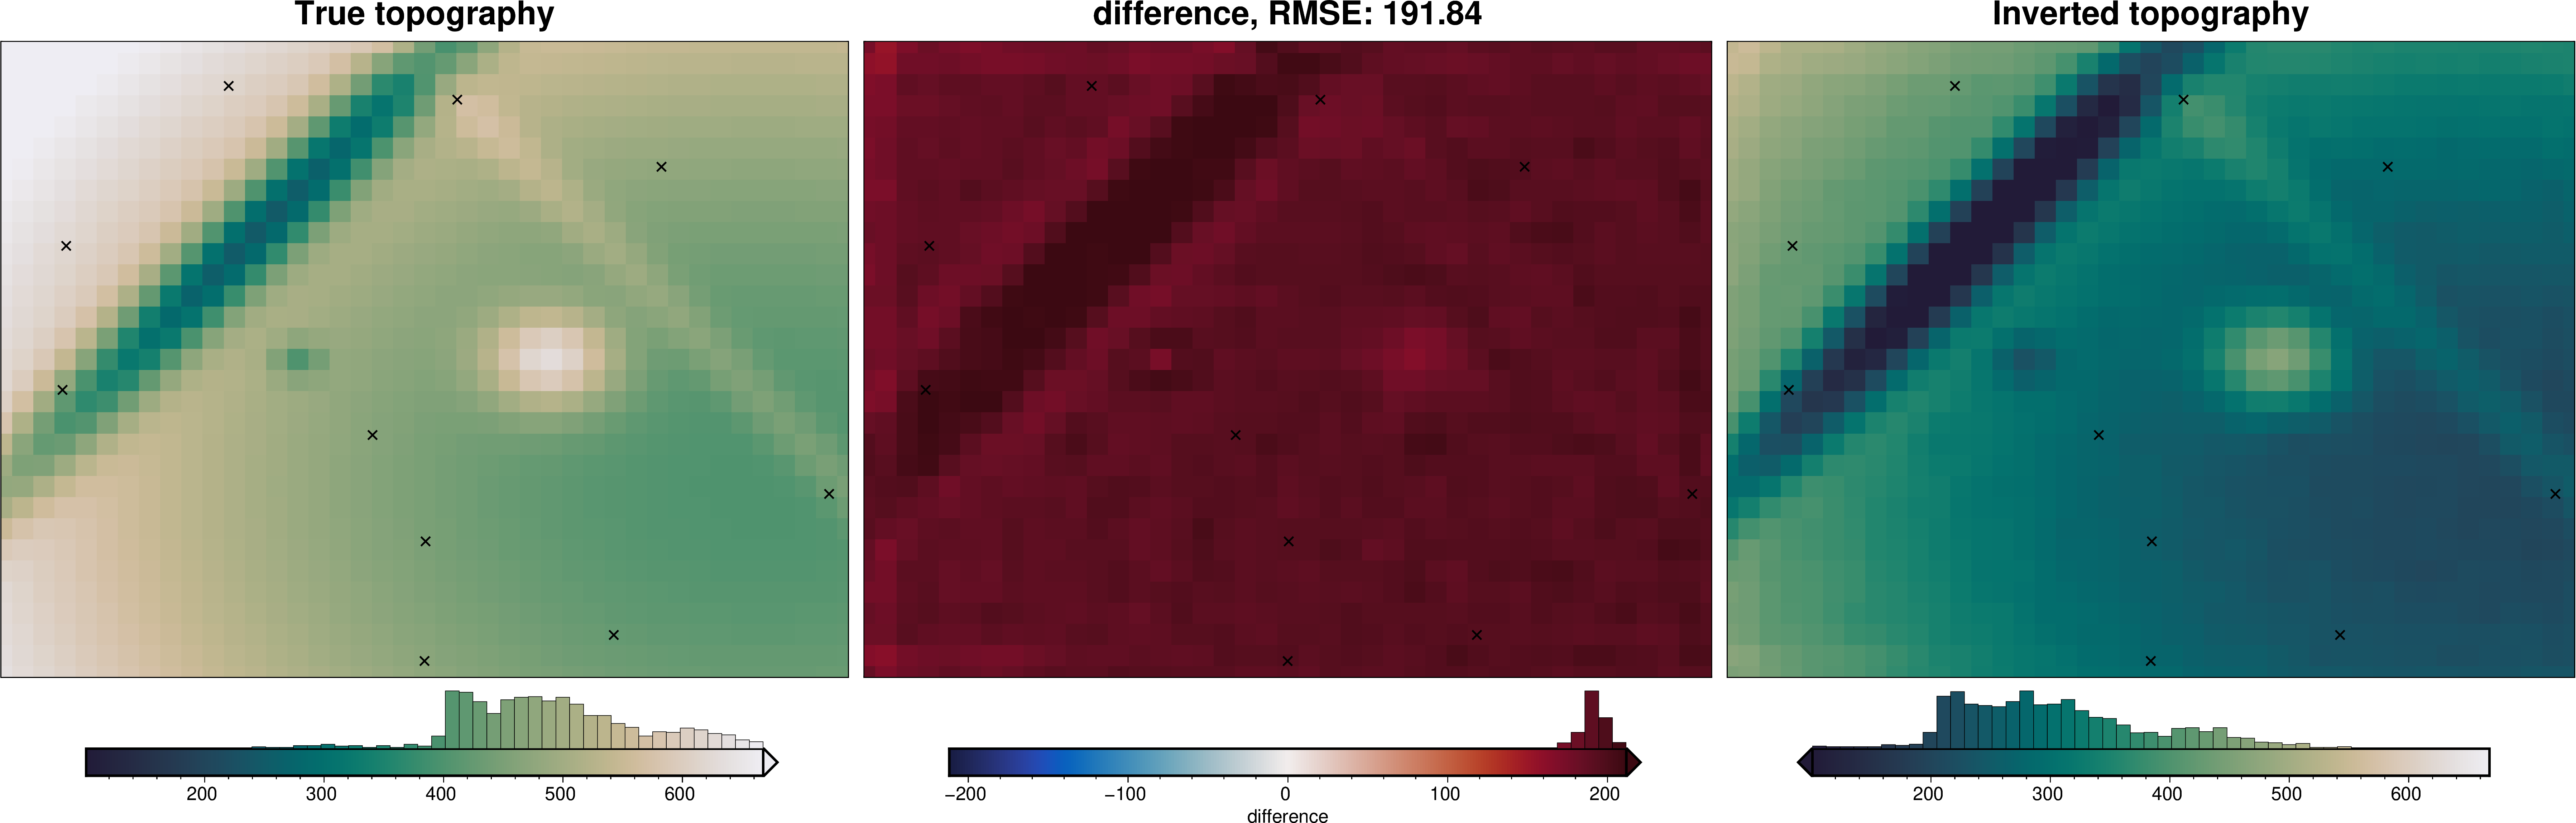

In [15]:
_ = polar_utils.grd_compare(
    true_topography,
    bad_zref_results.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

This inversion with a zref of 300m  instead of the optimal zref of ~490m, shows that an incorrect zref will result in an inverted topography which vertically offset from the true topography. Estimating and removing a regional component of the gravity misfit may help this, but the zref cross validation is an effect tool to reduce these errors.